In [3]:
!pip install graphframes

In [18]:
# import all tools

from pyspark.sql.functions import explode ##need to add
import numpy as np
from pyspark.sql import Row
import math
from graphframes import *
from itertools import combinations
import unittest
from pyspark.sql import types as T, SparkSession
from scipy.spatial import distance
from sklearn.datasets import make_blobs
from sklearn.cluster import DBSCAN
import numpy as np
from pyspark.sql import Row
import matplotlib.pyplot as plt
import time

Text(0.5, 1.0, 'Data1 Points')

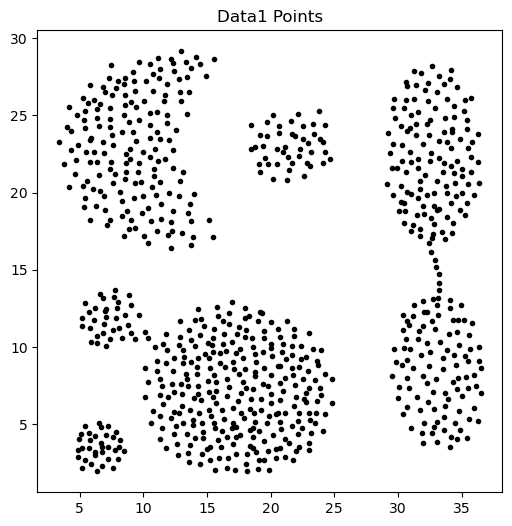

In [2]:
# Test1 data show
# 读取文件并分割成列表
with open('788points.txt', 'r') as file:
    lines = file.readlines()

# 初始化空列表，用于保存坐标
coordinates = []

# 遍历每一行，解析坐标并添加到列表中
for line in lines:
    x, y = line.strip().split(',')
    coordinates.append([float(x), float(y)])

# 将坐标列表转换为Numpy数组
coordinates_array = np.array(coordinates)

# 打印结果
plt.subplots(figsize=(6, 6))
plt.plot(coordinates_array[:, 0], coordinates_array[:, 1], 'o', markerfacecolor=[0, 0, 0, 1],
             markeredgecolor='k', markersize=3, scalex=1, scaley=1)
plt.title('Data1 Points')

Text(0.5, 1.0, 'Data2 Points')

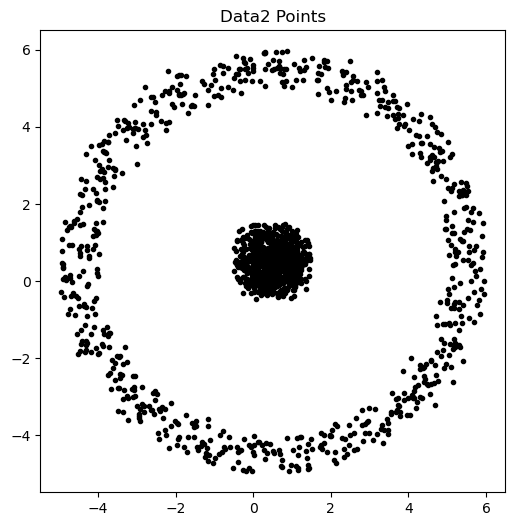

In [3]:
#Test2 data show

#random 生成圆数据集
num_samples = 750
theta = np.linspace(0, 2 * np.pi, num_samples)
X1 = np.random.rand(num_samples, 2) + np.transpose([0.5 * np.cos(theta), 0.5 * np.sin(theta) ])
X2 = np.random.rand(num_samples, 2) + np.transpose([5 * np.cos(theta), 5 * np.sin(theta) ])
circle = np.concatenate([X1, X2])

#打印结果
plt.subplots(figsize=(6, 6))
plt.plot(circle[:, 0], circle[:, 1], 'o', markerfacecolor=[0, 0, 0, 1],
             markeredgecolor='k', markersize=3, scalex=1, scaley=1)
plt.title('Data2 Points')

In [6]:
def __distance_from_pivot(pivot, dist, epsilon, operations):
    """
    Creates a distance function that computes the distance between a given data point and the pivot point.
    
    :param pivot: The pivot point used to compute distances
    :param dist: The distance function to calculate distances between points
    :param epsilon: The distance threshold for clustering
    :param operations: The accumulator for tracking the number of distance computations
    :return: A distance function that takes a data point as input and returns the partition indices and distances
    """
    def distance(x):
        pivot_dist = dist(x.value, pivot)
        if operations is not None:
            operations.add()
        partition_index = math.floor(pivot_dist / epsilon)
        rows = [Row(id=x.id, value=x.value, pivot_dist=dist(x.value, pivot))]
        out = [(partition_index, rows),
               (partition_index + 1, rows)]
        return out
    return distance

In [7]:
"""
Creates a scan function that finds neighboring data points within epsilon distance.
:param epsilon: The distance threshold for clustering
:param dist: The distance function to calculate distances between points
:param operations: The accumulator for tracking the number of distance computations
:return: A scan function that takes a tuple (partition index, list of data points) as input and returns a dictionary of neighboring points
"""
def __scan(epsilon, dist, operations):
    def scan(x):
        # out dictionary would have point id as key and a set of point ids who are within epsilon distance to
        # key point id. value is basically its neighbors
        out = {}
        # 0th index of x is partition_index
        # 1st index of x is data points
        partition_data = x[1]
        partition_len = len(partition_data)
        for i in range(partition_len):
            for j in range(i + 1, partition_len):
                if operations is not None:
                    operations.add()
                if dist(partition_data[i].value, partition_data[j].value) < epsilon:
                    # both i and j are within epsilon distance to each other
                    if partition_data[i].id in out:
                        out[partition_data[i].id].add(partition_data[j].id)
                    else:
                        out[partition_data[i].id] = set([partition_data[j].id])
                    if partition_data[j].id in out:
                        out[partition_data[j].id].add(partition_data[i].id)
                    else:
                        out[partition_data[j].id] = set([partition_data[i].id])
        # returns point and its neighbor as tuple
        return [Row(item[0], item[1]) for item in out.items()]

    return scan


In [8]:
def __label(min_pts):
    """
    Creates a label function that labels the points as core points or non-core points based on the number of neighbors.
    
    :param min_pts: The minimum number of neighbors required for a point to be considered a core point
    :return: A label function that takes a tuple (point id, set of neighboring point ids) as input and returns a list of tuples with point ids and cluster labels
    """
    def label(x):
        if len(x[1]) + 1 >= min_pts:
            # use id as cluster label
            cluster_label = x[0]
            # return True for core point
            out = [(x[0], [(cluster_label, True)])]
            for idx in x[1]:
                # return False for base point
                out.append((idx, [(cluster_label, False)]))
            return out
        return []

    return label


In [9]:
"""
Combines the cluster labels for each point.
:param x: A tuple (point id, list of (cluster label, core point indicator) tuples)
:return: A tuple (point id, list of cluster labels, core point indicator)
"""
def __combine_labels(x):
    # 0th element is the id of point
    # 1st element is the list of tuples with cluster and core point label
    point = x[0]
    core_point = False
    cluster_labels = x[1]
    clusters = []
    for (label, point_type) in cluster_labels:
        if point_type is True:
            core_point = True
        clusters.append(label)
    # if core point keep all cluster otherwise only one
    return point, clusters if core_point is True else [clusters[0]], core_point

In [10]:
#定义合并函数：将有共同核心点的临时聚类簇合并
def mergeSets(list_set):
    result = []
    while  len(list_set)>0 :
        cur_set = list_set.pop(0)
        intersect_idxs = [i for i in list(range(len(list_set)-1,-1,-1)) if cur_set&list_set[i]]
        while  intersect_idxs :
            for idx in intersect_idxs:
                cur_set = cur_set|list_set[idx]

            for idx in intersect_idxs:
                list_set.pop(idx)
                
            intersect_idxs = [i for i in list(range(len(list_set)-1,-1,-1)) if cur_set&list_set[i]]
        
        result = result+[cur_set]
    return result

#对rdd_core分区后在每个分区合并，不断将分区数量减少，最终合并到一个分区
#如果数据规模十分大，难以合并到一个分区，也可以最终合并到多个分区，得到近似结果。
#rdd: (min_core_id,core_id_set)
def mergeRDD(rdd,partition_cnt):
    def fn(iterator):
        list_set = [x[1] for x in iterator]
        list_set_merged = mergeSets(list_set)
        merged_core = [(min(x),x) for x in list_set_merged] 
        return(iter(merged_core))
    rdd_merged = rdd.partitionBy(partition_cnt).mapPartitions(fn)
    return rdd_merged

In [11]:
def process(spark, df, epsilon, min_pts, dist, dim, checkpoint_dir, operations=None):
    """
    Process given dataframe with DBSCAN parameters
    :param spark: spark session
    :param df: input data frame where each row has id and value keys
    :param epsilon: DBSCAN parameter for distance
    :param min_pts: DBSCAN parameter for minimum points to define core point
    :param dist: method to calculate distance. Only distance metric is supported.
    :param dim: number of dimension of input data
    :param checkpoint_dir: checkpoint path as required by Graphframe
    :param operations: class for managing accumulator to calculate number of distance operations
    :return: A dataframe of point id, cluster component and boolean indicator for core point
    """
    time1 = time.time()
    zero = df.rdd.takeSample(False, 1)[0].value
    combine_cluster_rdd = df.rdd.\
        flatMap(__distance_from_pivot(zero, dist, epsilon, operations)). \
        reduceByKey(lambda x, y: x + y).\
        flatMap(__scan(epsilon, dist, operations)). \
        reduceByKey(lambda x, y: x.union(y)).\
        flatMap(__label(min_pts)).\
        reduceByKey(lambda x, y: x + y).map(__combine_labels).cache()
    id_cluster_rdd = combine_cluster_rdd.\
        map(lambda x: Row(point=x[0], cluster_label=x[1][0], core_point=x[2]))
#     print(combine_cluster_rdd.collect())
    print('RDD part time:',time.time() - time1)
    try:
        #create (min_core_id,{core_id}) and (point_id , is_core)
        rdd_core = combine_cluster_rdd.map(lambda x: (min(x[1]), set(x[1])))
        rdd_all = combine_cluster_rdd.map(lambda x: (x[0], x[2]))
        #此处需要视实际情况调整分区数量和迭代数量
        for pcnt in (16,8,4,2,1):
            rdd_core = mergeRDD(rdd_core,pcnt)
        rdd_core = rdd_core.map(lambda x: (x[0], list(x[1])))
        df1 = spark.createDataFrame(rdd_core, ["component", "core_points"])
        df1 = df1.select("component", explode("core_points").alias("point"))

        # 创建第二个RDD的DataFrame
        df2 = spark.createDataFrame(rdd_all, ["point", "core_point"])

        # 连接两个DataFrame
        result = df1.join(df2, on='point', how='outer')
        
        # 定以所有border_point
        result = result.fillna(-1, subset=['component'])
        print('Merge part time:',time.time() - time1)
        return result
    except ValueError:
        return None

In [12]:
def ReaddataToDF(filename):
    """
    Reads data from a file and converts it into a DataFrame.
    
    :param filename: The name of the file containing the data
    :return: A DataFrame with columns "id" and "value"
    """
    data = spark.read.text(filename).rdd.map(lambda r: r[0].split(',')).zipWithIndex().map(lambda r: Row(id=r[1],value=(float(r[0][0]),float(r[0][1]))))
    schema = T.StructType([
    T.StructField("id", T.IntegerType(), False),
    T.StructField("value", T.ArrayType(T.FloatType()), False)
    ])
    df = spark.createDataFrame(data, schema)
    return df

In [13]:
def dist(x, y):
    """
    Calculates the Euclidean distance between two points.
    
    :param x: The first point
    :param y: The second point
    :return: The Euclidean distance between x and y
    """
    return distance.euclidean(x, y)

In [106]:
# Test1 algorithm on 788data

#load data
df = ReaddataToDF("788points.txt")

#fit DBScan
df_clusters = process(spark, df, 1, 5, dist, 2, "checkpoint")
out = df_clusters.distinct().select('point','component')

# data_row was used to plot
data_rows  = out.select(out.point.alias('id'),out.component.alias('label')).join(df,'id').collect()

#show result
# print(data_rows)

RDD part time: 0.08853459358215332
Merge part time: 0.9296505451202393


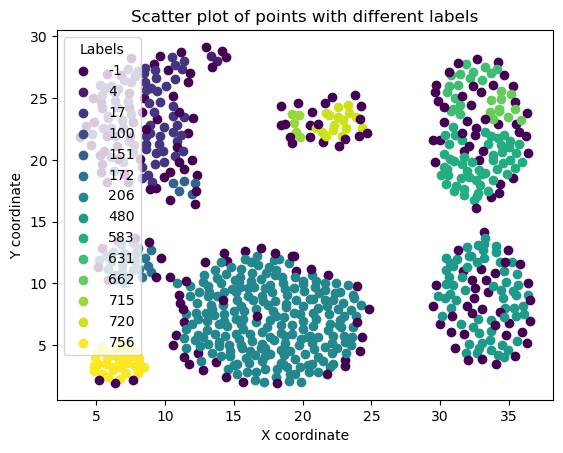

In [107]:
# Plot Test1 result
# Convert the Row objects to dictionaries
data_dicts = [row.asDict() for row in data_rows]

# Get unique labels
labels = sorted(set([d["label"] for d in data_dicts]))

# Create a colormap for labels
cmap = plt.cm.get_cmap("viridis", len(labels))

# Plot the points with different colors based on their label
for d in data_dicts:
    plt.scatter(
        d["value"][0], d["value"][1], color=[cmap(labels.index(d["label"]) / len(labels))]
    )

# Add legend to the plot
handles = [plt.scatter([], [], color=cmap(i / len(labels))) for i in range(len(labels))]
plt.legend(handles, labels, title="Labels", loc="best")

# Show the plot
plt.xlabel("X coordinate")
plt.ylabel("Y coordinate")
plt.title("Scatter plot of points with different labels")
plt.show()

In [103]:
# Test1 algorithm on circle

# Define the schema
schema = T.StructType([
    T.StructField("id", T.IntegerType(), False),
    T.StructField("value", T.ArrayType(T.FloatType()), False)
])

# Convert the data to the desired format
formatted_data = [(i, [float(x), float(y)]) for i, (x, y) in enumerate(circle, start=1)]

# Create a DataFrame
df_circle = spark.createDataFrame(formatted_data, schema=schema)

#fit DBScan
dfcircle_clusters = process(spark, df_circle, 1, 5, dist, 2, "checkpoint")
out = dfcircle_clusters.distinct().select('point','component')

# data_row was used to plot
datacircle_rows  = out.select(out.point.alias('id'),out.component.alias('label')).join(df_circle,'id').collect()

#show result
print(datacircle_rows)


RDD part time: 0.23494291305541992


Merge part time: 4.275768756866455
[Row(id=26, label=1, value=[1.0070445537567139, 0.8918381929397583]), Row(id=29, label=1, value=[0.9461911916732788, 0.18295975029468536]), Row(id=65, label=1, value=[1.1327983140945435, 0.944943368434906]), Row(id=19, label=1, value=[1.0453468561172485, 0.7836480140686035]), Row(id=54, label=1, value=[1.087013840675354, 0.7919015884399414]), Row(id=22, label=1, value=[0.6949643492698669, 0.30681273341178894]), Row(id=7, label=1, value=[0.6949796080589294, 0.936852216720581]), Row(id=77, label=1, value=[1.2517321109771729, 0.4133962094783783]), Row(id=34, label=1, value=[0.673387348651886, 0.7492244839668274]), Row(id=50, label=1, value=[0.8039983510971069, 0.33379578590393066]), Row(id=57, label=1, value=[0.7744241952896118, 1.1370514631271362]), Row(id=32, label=1, value=[1.0794384479522705, 0.8716788291931152]), Row(id=43, label=1, value=[0.6692167520523071, 0.7846540212631226]), Row(id=84, label=1, value=[0.5218965411186218, 0.5725894570350647]), 

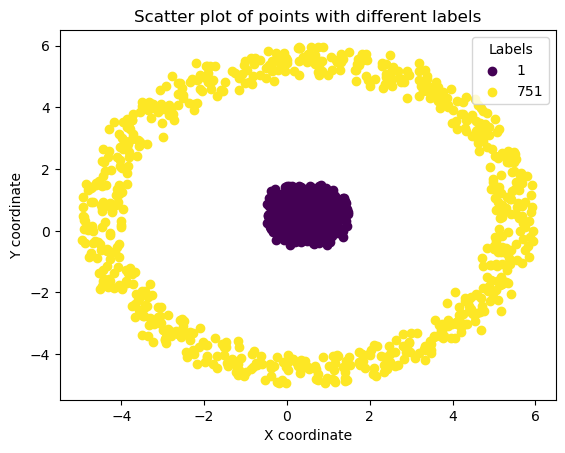

In [104]:
# Plot Test2 result
# Convert the Row objects to dictionaries
data_dicts = [row.asDict() for row in datacircle_rows]

# Get unique labels
labels = sorted(set([d["label"] for d in data_dicts]))

# Create a colormap for labels
cmap = plt.cm.get_cmap("viridis", len(labels))

# Plot the points with different colors based on their label
for d in data_dicts:
    plt.scatter(
        d["value"][0], d["value"][1], color=[cmap(labels.index(d["label"]) / len(labels))]
    )

# Add legend to the plot
handles = [plt.scatter([], [], color=cmap(i / len(labels))) for i in range(len(labels))]
plt.legend(handles, labels, title="Labels", loc="best")

# Show the plot
plt.xlabel("X coordinate")
plt.ylabel("Y coordinate")
plt.title("Scatter plot of points with different labels")
plt.show()

In [15]:
def ReaddataToDF1(filename):
    """
    Reads data from a file and converts it into a DataFrame.

    :param filename: The name of the file containing the data
    :return: A DataFrame with columns "id" and "value"
    """
    data = spark.read.text(filename).rdd.map(lambda r: r[0].split()).zipWithIndex().map(
        lambda r: Row(id=r[1], value=(float(r[0][0]), float(r[0][1]))))
    schema = T.StructType([
        T.StructField("id", T.IntegerType(), False),
        T.StructField("value", T.ArrayType(T.FloatType()), False)
    ])
    df = spark.createDataFrame(data, schema)
    return df

In [19]:
# Test1 algorithm on s1.txt(5000 points dataset)

#load data
df = ReaddataToDF1("s1.txt")
#print(df.take(5))
#fit DBScan
start_time = time.time()
df_clusters = process(spark, df, 10000, 10, dist, 2, "checkpoint")
end_time = time.time()
print("Computation time is ", end_time-start_time)

out = df_clusters.distinct().select('point','component')

# data_row was used to plot
data_rows1  = out.select(out.point.alias('id'),out.component.alias('label')).join(df,'id').collect()

#show result
print(len(data_rows1))

RDD part time: 0.24281811714172363


Merge part time: 10.91111707687378
Computation time is  10.91135311126709
3260


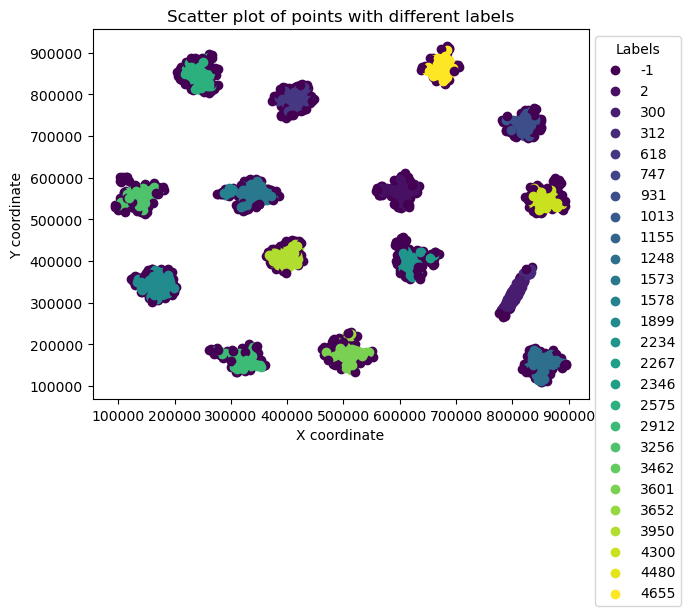

In [20]:
# Plot Test1 result
# Convert the Row objects to dictionaries
data_dicts = [row.asDict() for row in data_rows1]

# Get unique labels
labels = sorted(set([d["label"] for d in data_dicts]))

# Create a colormap for labels
cmap = plt.cm.get_cmap("viridis", len(labels))

# Plot the points with different colors based on their label
for d in data_dicts:
    plt.scatter(
        d["value"][0], d["value"][1], color=[cmap(labels.index(d["label"]) / len(labels))]
    )

# Add legend to the plot
handles = [plt.scatter([], [], color=cmap(i / len(labels))) for i in range(len(labels))]
plt.legend(handles, labels, title="Labels", bbox_to_anchor=(1, 1))

# Show the plot
plt.xlabel("X coordinate")
plt.ylabel("Y coordinate")
plt.title("Scatter plot of points with different labels")
plt.show()